In [1]:
import numpy as np
from scipy.stats import pearsonr
import pandas as pd


# plotting modules
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 5, 'ytick.major.width': 1.5, 'ytick.major.size': 4})
from matplotlib.backends.backend_pdf import PdfPages

# for custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

In [3]:
all_lib_names = ["IN", "CC", "ATF2", "CTCF", "FOXA1", "LEF1", "SCRT1", "TCF7L2", "16P12_1"]
meta_frag_cov_file = "/data5/deepro/starrseq/papers/reproducibility/3_read_lib_qc/data/in_house/cov/meta_cov.csv"
meta_peak_cov_file = "/data5/deepro/starrseq/papers/reproducibility/5_peak_qc/data/peak_cov/meta_cov.csv"


In [4]:
def create_frag_lib_dfs(meta_frag_cov_df, all_lib_names):
    frag_cov_dfs = []
    for lib_name in all_lib_names:
        lib_cov_df = meta_frag_cov_df.loc[:, [c for c in meta_frag_cov_df.columns if f"{lib_name}_" in c]]
        frag_cov_dfs.append(lib_cov_df)
    return frag_cov_dfs

def create_peak_fc_lib_dfs(meta_peak_cov_df, all_lib_names, in_lib_name):
    peak_fc_dfs = []

    for lib_name in all_lib_names:
        in_peak_cov_df = meta_peak_cov_df.loc[:, [c for c in meta_peak_cov_df.columns if f"{in_lib_name}_" in c]]
        out_peak_cov_df = meta_peak_cov_df.loc[:, [c for c in meta_peak_cov_df.columns if f"{lib_name}_" in c]]
        lib_peak_fc_df = out_peak_cov_df.div(in_peak_cov_df.values, axis="index")
        lib_peak_fc_df.index = meta_peak_cov_df.index
        peak_fc_dfs.append(lib_peak_fc_df)
    return peak_fc_dfs

def get_within_replicate_correlation(df):
    pcorrs = dict()
    scorrs = dict()
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            replicates = f"Replicate {i+1} vs {j+1}"
            prep_corr = df.iloc[:, i].corr(df.iloc[:, j], method="pearson")
            srep_corr = df.iloc[:, i].corr(df.iloc[:, j], method="spearman")
            pcorrs[replicates] = round(prep_corr, 4)
            scorrs[replicates] = round(srep_corr, 4)
    return pcorrs, scorrs

def make_lib_corr_df(all_lib_names, lib_dfs):
    data_dict = {
        "library": [],
        "replicates": [],
        "pearson correlation": [],
        "spearman correlation": []
    }


    for lib_name, lib_df in zip(all_lib_names, lib_dfs):
        pcorrs, scorrs = get_within_replicate_correlation(lib_df)
        for r,c in pcorrs.items():
            data_dict["library"].append(lib_name)
            data_dict["replicates"].append(r)
            data_dict["pearson correlation"].append(c)
            data_dict["spearman correlation"].append(scorrs[r])
        
    df_lib_corr = pd.DataFrame(data_dict)
    return df_lib_corr

In [5]:
meta_frag_cov_df = pd.read_csv(meta_frag_cov_file)
meta_peak_cov_df = pd.read_csv(meta_peak_cov_file, index_col=[0,1,2]).drop_duplicates()

In [6]:
frag_read_dfs = create_frag_lib_dfs(meta_frag_cov_df, all_lib_names)
peak_fc_dfs = create_peak_fc_lib_dfs(meta_peak_cov_df, all_lib_names, "IN")

In [7]:
lib_frag_corr_df = make_lib_corr_df(all_lib_names, frag_read_dfs)
lib_peak_corr_df = make_lib_corr_df(all_lib_names, peak_fc_dfs)

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [8]:
lib_frag_corr_df.replicates.unique()

array(['Replicate 1 vs 2', 'Replicate 1 vs 3', 'Replicate 2 vs 3'],
      dtype=object)

In [9]:
colors_to_use = ["#08509b", "#ff7f0e", "#dc2924"]

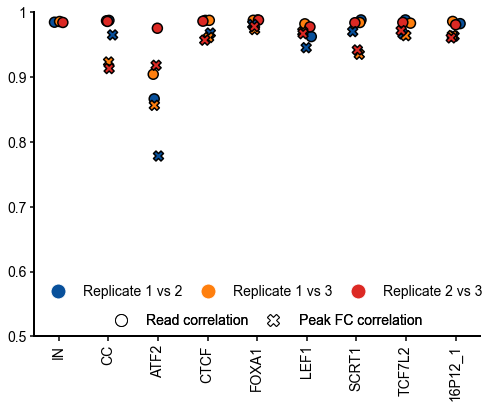

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8, 4.5))

read_ax = sns.stripplot(
    data=lib_frag_corr_df, x="library", y="spearman correlation", hue="replicates", palette=colors_to_use, s=10, linewidth=1.5, marker="o", edgecolor="k", 
    ax=ax, order=all_lib_names, hue_order=lib_frag_corr_df.replicates.unique(),
)

peak_ax = sns.stripplot(
    data=lib_peak_corr_df, x="library", y="spearman correlation", hue="replicates", palette=colors_to_use, s=10, linewidth=1.5, marker="X",edgecolor="k", 
    ax=ax, order=all_lib_names, hue_order=lib_frag_corr_df.replicates.unique(),
)
# 
read_ax.legend_.remove()

ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig.subplots_adjust(top=1.5, bottom=0.5)
ax.set_ylim([0.5, 1.0])
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(list(map(str, [0.5, 0.6, 0.7, 0.8, 0.9, 1])))
ax.spines[['right', 'top']].set_visible(False)

# add your own legends
legend1_elements = [Line2D([0], [0], marker='o', markerfacecolor="#08509b", label='Replicate 1 vs 2', color='w', markersize=15),
                   Line2D([0], [0], marker='o', markerfacecolor="#ff7f0e", label='Replicate 1 vs 3', color='w', markersize=15),
                   Line2D([0], [0], marker='o', markerfacecolor="#dc2924", label='Replicate 2 vs 3', color='w', markersize=15),
                   ]
legend2_elements = [Line2D([0], [0], marker='o', markerfacecolor="w", label='Read correlation', color='w', markersize=12, markeredgecolor="k", markeredgewidth=1.),
                   Line2D([0], [0], marker='X', markerfacecolor="w", label='Peak FC correlation', color='w', markersize=12, markeredgecolor="k", markeredgewidth=1.),
                   ]
legend1 = ax.legend(handles=legend1_elements, loc=(0.01,0.1), ncol=3, frameon=False, columnspacing=0.8)
legend2 = ax.legend(handles=legend2_elements, loc=(0.15,0.01), ncol=3, frameon=False, columnspacing=0.8)
ax.add_artist(legend1)
ax.add_artist(legend2)
# peak_ax.legend(loc=(0.01,0.07), prop={"size": 16}, ncol=3)

In [11]:
save_file = "../data/figures/read_peak_corr.pdf"
save_pdf(save_file, fig)